## The objectives are as follows:


- Respond to Business Requirement 2:

    - There is a client who wants to know whether a given image of a cherry leaf is healthy or if it has powdery mildew.



## Inputs


    Following sets:

* Train

* Validation

* Test



## Outputs


- Images distribution plot in train, validation, and test set.

- Increasing data diversity by enhancing images.

- Adjusting label predictions during inference by modifying class indices.

- Machine learning model creation and training.

- The trained model should be preserved (saved).

- The learning curve is plotted to visualize the performance of the model.

- Evaluating the model's performance.

- Making predictions on a randomly selected image file.

In [ ]:
%pip install -r /workspace/project5/requirements.txt


In [ ]:
import os
current_dir = os.getcwd()
current_dir



In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

In [ ]:
work_dir = os.getcwd()
work_dir

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras



In [ ]:
my_data_dir = 'inputs/datasets/cherry-leaves' 
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('There is a version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


In [ ]:
labels = os.listdir(train_path)

print(f"The project labels are: {labels}")

version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/images_shapes.pkl")
image_shape

### Retrieve the counts of images in the train, validation, and test datasets, and generate a plot displaying the distribution of images across these datasets.

In [ ]:
image_counts = []
for folder in ['train', 'validation', 'test']:
    counts = [len(os.listdir(f"{my_data_dir}/{folder}/{label}")) for label in labels]
    image_counts.extend(zip([folder]*len(labels), labels, counts))
    print('\n'.join([f"* {folder} - {label}: {count} images" for label, count in zip(labels, counts)]))

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=pd.DataFrame(image_counts, columns=['Set', 'Label', 'Frequency']), x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()
#---------------------------------------------

### Enhancing the training process, by utilizing the ImageDataGenerator library to employ image data augmentation techniques. This will create a varied set of temporary images within the training dataset, thereby enhancing the training process

### Visualize Augmented Training Images##

In [ ]:
training_batch_size = 20

augmented_test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,                                                                            
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=False
)


augmented_train_set = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
).flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=True
)


augmented_validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=False
)

print("Test class Found {0} images belonging to {1} classes.".format(augmented_test_set.samples, len(augmented_test_set.class_indices)))

print("Train class Found {0} images belonging to {1} classes.".format(augmented_train_set.samples, len(augmented_train_set.class_indices)))

print("Validation class Found {0} images belonging to {1} classes.".format(augmented_validation_set.samples, len(augmented_validation_set.class_indices)))

#---------------------------------------------

In [ ]:
for _ in range(10):
    img, label = augmented_test_set.next()
    plt.imshow(img[0])
    plt.show()
    #---------------------------------------------

In [ ]:
# TO FIX - Not showing data - Fixed by correctin syntax in code. Had no rescaling
for _ in range(10):
    img, label = augmented_train_set.next()
    plt.imshow(img[0])
    plt.show()
    #---------------------------------------------

In [ ]:

for _ in range(10):
    img, label = augmented_validation_set.next()
    plt.imshow(img[0])
    plt.show()
    #---------------------------------------------

In [ ]:
joblib.dump(value=augmented_train_set.class_indices,
            filename=f"{file_path}/train_classes_indices.pkl")

# Creating the model section:

#### - Creating an image classification model using convolutional, pooling, dense, and dropout layers, compiles it, and returns the model. Summary() method is then called to display the model architecture summary.

In [89]:
def create_image_classification_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
create_image_classification_model().summary()


# ----------------------------


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 6, 6, 64)       

- Training an image classification model using 'augmented_train_set' dataset and validating it using the 'augmented_validation_set' dataset. EarlyStopping callback to stop training if the validation accuracy does not improve for _5_ consecutive epochs.

In [90]:
model = create_image_classification_model()

model.fit(augmented_train_set,
          epochs=10,
          validation_data=augmented_validation_set,
          verbose=1)

model.save('outputs/v1/cherry_disease_model.h5')
print(f"Model saved as {model}")

#----------------------------------------------



Epoch 1/10


2023-05-22 13:49:34.455824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.8118

2023-05-22 13:49:41.348174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


148/148 [==============================] - 7s 43ms/step - loss: 0.3663 - accuracy: 0.8118 - val_loss: 0.1041 - val_accuracy: 0.9738
Epoch 2/10
148/148 [==============================] - 5s 34ms/step - loss: 0.1212 - accuracy: 0.9616 - val_loss: 0.0558 - val_accuracy: 0.9690
Epoch 3/10
148/148 [==============================] - 5s 34ms/step - loss: 0.0880 - accuracy: 0.9766 - val_loss: 0.0213 - val_accuracy: 0.9929
Epoch 4/10
148/148 [==============================] - 9s 63ms/step - loss: 0.0524 - accuracy: 0.9847 - val_loss: 0.0635 - val_accuracy: 0.9738
Epoch 5/10
148/148 [==============================] - 8s 56ms/step - loss: 0.0425 - accuracy: 0.9868 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 6/10
148/148 [==============================] - 5s 33ms/step - loss: 0.0467 - accuracy: 0.9888 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 7/10
148/148 [==============================] - 5s 33ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 8/10

# Checking the performance of the created model

- Generating two plots: one for the loss values and one for the accuracy values from the model training history. Print plots as images.

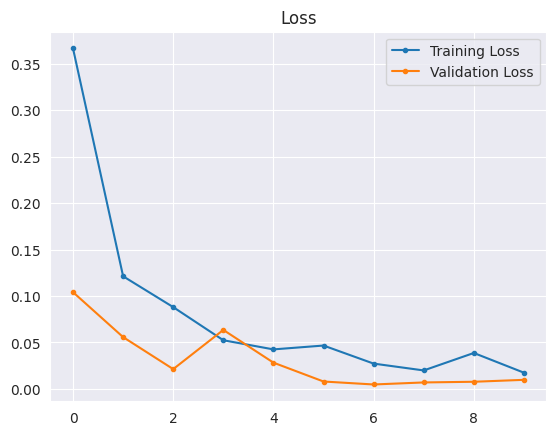

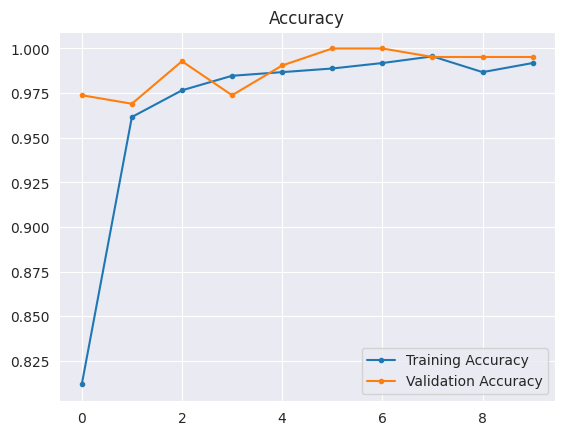

In [91]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.legend(['Training Loss', 'Validation Loss'])  # Change legend labels
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.legend(['Training Accuracy', 'Validation Accuracy'])  # Change legend labels
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()
#---------------------------------------------


# Evaluating the created Model 

- 


In [92]:
evaluation = model.evaluate(augmented_test_set)
joblib.dump(value=evaluation,
            filename=f"outputs/v1/model_evaluation.pkl")
#---------------------------------------------

13/43 [========>.....................] - ETA: 0s - loss: 7.4943e-05 - accuracy: 1.0000

2023-05-22 13:50:42.819639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 1s 12ms/step - loss: 0.0038 - accuracy: 0.9988


['outputs/v1/model_evaluation.pkl']

 # Prediction on new data

# Summary

### To Fix:
- play around with Patience (L53)and epoch (l53)
- loss and val_accuracy don't seem to be good - There is high loss (0.7) and and low accuracy (0.5)
- "for _ in range(5):img, label = augmented_train_set.next()" is not showing any images - Fixed issue
- editing code for loss and val_accuracy leads to improvemnetsin the accuracy plot only. needs fine tuning
- Tried increasing augmented data from 2 to 10 range to see if that improves accuracy. 
- Fixed Loss accuracy as I was selecting the wrong columns. Corrected "losses[['loss', 'val_accuracy']].plot(style='.-')" to "losses[['loss', 'val_loss']].plot(style='.-')"